<a href="https://colab.research.google.com/github/kumar045/Assignment-For-Filed/blob/main/5_Step_Guide_to_generate_3D_meshes_from_point_clouds_with_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

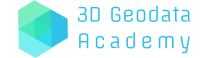

Created by Florent Poux. Licence MIT.
Members of the [3D Geodata Academy](https://learngeodata.eu) enrolled in a Course can use the code with Privileged IP Rights.

*   To reuse in your project, please tag me on [Linkedin](https://www.linkedin.com/in/florent-poux-point-cloud/), [Medium](https://medium.com/@florentpoux) or [Twitter](https://twitter.com/PouxPointCloud).
*   Have fun with this notebook that you can very simply run (ctrl+Enter) !
*   The first time thought, it will ask you to get a key for it to be able to acces your Google drive folders if you want to work all remotely.
*   Simply accept, and then change the input path by the folder path containing your data, on Google Drive.

Enjoy!

# Step 1: Setting up the environment

In [ ]:
#http://www.open3d.org/docs/release/index.html
!pip install open3d

# Step 2: Load and prepare the data

In [ ]:
#This code snippet allows to use data directly from your Google drives files.
#If you want to use a shared folder, just add the folder to your drive
from google.colab import drive
drive.mount('/content/gdrive')

#libraries used
import numpy as np
import open3d as o3d

In [ ]:
#create paths and load data
input_path="your_path_to_file/"
output_path="your_path_to_output_folder/"
dataname="sample_w_normals.xyz"
point_cloud= np.loadtxt(input_path+dataname,skiprows=1)

In [ ]:
#Format to open3d usable objects
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud[:,:3])
pcd.colors = o3d.utility.Vector3dVector(point_cloud[:,3:6]/255)
pcd.normals = o3d.utility.Vector3dVector(point_cloud[:,6:9])

# Step 3: Choose a meshing strategy

Now we are ready to start the surface reconstruction process by meshing the pcd point cloud. I will give my favorite way to efficiently obtain results, but before we dive in, some condensed details ar necessary to grasp the underlying processes. I will limit myself to two meshing strategies. See article

# Step 4: Process the data
## Strategy 1: BPA

In [ ]:
#radius determination
distances = pcd.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
radius = 3 * avg_dist

In [ ]:
#computing the mehs
bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd,o3d.utility.DoubleVector([radius, radius * 2]))

In [ ]:
#decimating the mesh
dec_mesh = mesh.simplify_quadric_decimation(100000)

*Optional ---*

In [ ]:
dec_mesh.remove_degenerate_triangles()
dec_mesh.remove_duplicated_triangles()
dec_mesh.remove_duplicated_vertices()
dec_mesh.remove_non_manifold_edges()

## Strategy 2: Poisson' reconstruction

In [ ]:
#computing the mesh
poisson_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8, width=0, scale=1.1, linear_fit=False)[0]

In [ ]:
#cropping
bbox = pcd.get_axis_aligned_bounding_box()
p_mesh_crop = poisson_mesh.crop(bbox)

# Step 5: Export and visualize

In [ ]:
#export
o3d.io.write_triangle_mesh(output_path+"bpa_mesh.ply", dec_mesh)
o3d.io.write_triangle_mesh(output_path+"p_mesh_c.ply", p_mesh_crop)

In [ ]:
#function creation
def lod_mesh_export(mesh, lods, extension, path):
    mesh_lods={}
    for i in lods:
        mesh_lod = mesh.simplify_quadric_decimation(i)
        o3d.io.write_triangle_mesh(path+"lod_"+str(i)+extension, mesh_lod)
        mesh_lods[i]=mesh_lod
    print("generation of "+str(i)+" LoD successful")
    return mesh_lods

In [ ]:
#execution of function
my_lods = lod_mesh_export(bpa_mesh, [100000,50000,10000,1000,100], ".ply", output_path)

In [ ]:
#execution of function
my_lods2 = lod_mesh_export(bpa_mesh, [8000,800,300], ".ply", output_path)